In [1]:
import numpy as np
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from Mesh.Charges_utils import get_charges_list
from Model.Solutions_utils import Solution_utils
from Simulation import get_simulation_name

simulation_name,results_path,main_path,logger = get_simulation_name(os.path.join(os.path.dirname(os.getcwd()), 'dataset.py'))

file_path = os.getcwd()

In [2]:

molecule = 'born_ion'


Rs = {'born_ion': 1,
      'methanol': 2.54233,
      'methanol_E': 2.54233,
      'arg': 5.9695745,
      'sphere': 1.2,
      'sphere_+1-1': 1.2,
      'sphere_+1+1': 1.2,
      'sphere_+2-1': 1.2,
      'sphere_+1_D': 1.2,
      'sphere_0.2': 1.2}

Model = Solution_utils()

Model.pqr_path = os.path.join(os.getcwd(),molecule,f'{molecule}.pqr')
q_list = get_charges_list(Model.pqr_path)

Model.domain_properties = {
        'molecule': molecule,
        'epsilon_1':  1,
        'epsilon_2': 80,
        'kappa': 0.125,
        'T' : 300 
        }

Model.epsilon_1 = Model.domain_properties['epsilon_1']
Model.epsilon_2 = Model.domain_properties['epsilon_2']
Model.kappa = Model.domain_properties['kappa']
Model.pi = np.pi
Model.q_list = q_list

n = len(Model.q_list)
Model.qs = np.zeros(n)
Model.x_qs = np.zeros((n,3))
for i,q in enumerate(Model.q_list):
    Model.qs[i] = q.q
    Model.x_qs[i,:] = q.x_q
Model.total_charge = np.sum(Model.qs)

dR = 0.15
R_mol = Rs[molecule]
Rmin = dR + R_mol
Rmax = Rmin + 3

Model.mesh_density = 3
Model.mesh_generator = 'msms'
Model.DTYPE = 'float64'

In [3]:
q_list

[Charges(q=1.0, x_q=array([0., 0., 0.]), r_q=1.0, atom_name='I', res_name='SPH', res_num='1', ion_r_explode=3.5)]

### Calculate Solvation energy

In [5]:
phi_q = Model.Harmonic_spheres(Model.x_qs,'molecule',R_mol)
print(Model.solvation_energy_phi_qs(phi_q))
print(phi_q)
Model.solvation_energy_phi_qs(phi_q)

-73.13704757700724
[-0.0149601  -0.01451289 -0.0165293  -0.01756816 -0.01609127 -0.01400082
 -0.01420401 -0.01449526 -0.01436105 -0.01478346 -0.01487474 -0.01501364
 -0.01465445 -0.01440891 -0.01448955 -0.01504634 -0.01500428 -0.01502074
 -0.01554073 -0.01578378 -0.01580813 -0.01551957 -0.01506542 -0.01584317
 -0.01652246 -0.01676533 -0.01704408]


-73.13704757700724

### Create data_known file

In [4]:

def calculate_print_phi(domain,method, num_points, file):

    R = R_mol if domain == 'molecule' else Rmax if domain == 'solvent' else None
    x = np.random.uniform(-R, R, num_points)
    y = np.random.uniform(-R, R, num_points)
    z = np.random.uniform(-R, R, num_points)
    r = np.sqrt(x**2+y**2+z**2)
    X = np.stack([x,y,z], axis=1)

    phi_values = Model.phi_known(method,'phi',X,domain,R_mol)

    if domain == 'molecule':
        for i in range(num_points):
            condition = 1 if r[i] <= R_mol else 2
            if r[i]<R_mol:
                file.write(f"{condition} {x[i]} {y[i]} {z[i]} {phi_values[i]}\n")

    elif domain == 'solvent':
        for i in range(num_points):
            condition = 1 if r[i] <= R_mol else 2
            if r[i]>Rmin and r[i]<Rmax:
                file.write(f"{condition} {x[i]} {y[i]} {z[i]} {phi_values[i]}\n")

In [5]:
with open(os.path.join(file_path,molecule,'data_known.dat'), 'w') as file:
    calculate_print_phi('solvent','G_Yukawa',300, file)
    # calculate_print_phi('molecule','Harmonic_spheres',300, file)

print('File created')

File created


### TESTS

In [21]:
with open(os.path.join(file_path,molecule,'data_known_saved.dat'), 'r') as file:
    lines = file.readlines()

column1 = []
column2 = []
column3 = []
column4 = []
column5 = []

for line in lines:
    values = [float(val) for val in line.strip().split()]

    column1.append(values[0])
    column2.append(values[1])
    column3.append(values[2])
    column4.append(values[3])
    column5.append(values[4])

x = np.array(column2).reshape(-1,1)
y = np.array(column3).reshape(-1,1)
z = np.array(column4).reshape(-1,1)
phi = np.array(column5).reshape(-1,1)

In [22]:
kappa = 0.125
epsilon_2 = 80

def G_Yukawa(x,y,z):
    sum = 0
    for q_obj in q_list:
        qk = q_obj.q
        xk,yk,zk = q_obj.x_q
        r = np.sqrt((x-xk)**2+(y-yk)**2+(z-zk)**2)
        sum += qk*np.exp(-kappa*r)/r
    return (1/(4*np.pi*epsilon_2))*sum

In [23]:
phi_yuk = G_Yukawa(x,y,z)

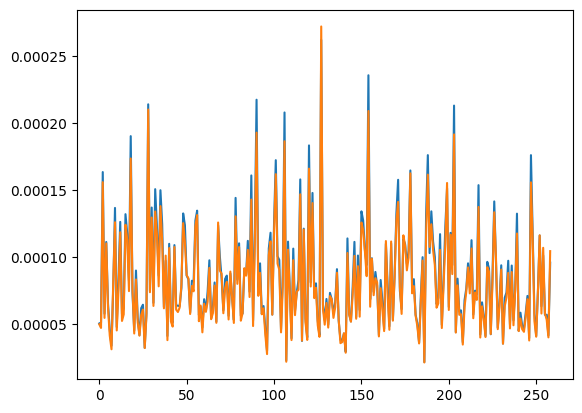

In [24]:
import matplotlib.pyplot as plt
plt.plot(phi)
plt.plot(phi_yuk)

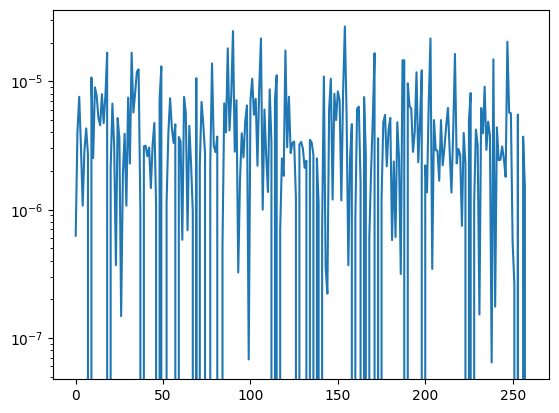

In [26]:
plt.plot(phi-phi_yuk)
plt.yscale('log')

In [31]:
phi[2]

array([0.00016353])

In [32]:
phi_yuk[2]

array([0.00015597])

In [35]:
with open(os.path.join(file_path,molecule,'data_known.dat'), 'w') as file:   
    for i in range(len(x)):
        file.write(f"{2} {x[i,0]} {y[i,0]} {z[i,0]} {phi_yuk[i,0]}\n")